# Application examples for `monvi`

In [1]:
import glob
from pathlib import Path

import numpy as np
import scipy as sp
import cvxpy as cp
import matplotlib.pyplot as plt

from monvi import VI

In [16]:
I = np.eye

GOLDEN_RATIO = 0.5*(np.sqrt(5) + 1)

def cases(x0, L, only={}, excluded={}):
    cases_list = {
        "pg": {"x": x0[0], "step_size": 2/L**2},
        "eg": {"x": x0[0], "step_size": 1/L},
        "popov": {"x": x0[0], "y": x0[1], "step_size": 1/(2*L)},
        "fbf": {"x": x0[0], "step_size": 1/L},
        "frb": {"x_current": x0[0], "x_previous": x0[1], "step_size": 1/(2*L)}, 
        "prg": {"x_current": x0[0], "x_previous": x0[1], "step_size": (np.sqrt(2)-1)/L},
        "eag": {"x": x0[0], "step_size": (np.sqrt(2) - 1)/L},
        "arg": {"x_current": x0[0], "x_previous": x0[1], "step_size": 1/(np.sqrt(3)*L)}, 
        "fogda": {"x_current": x0[0], "x_previous": x0[1], "y": x0[0], "step_size": 1/(4*L)},
        "graal": {"x": x0[0], "y": x0[1], "step_size": GOLDEN_RATIO/(2*L)},
        "agraal": {"x_current": x0[1], "x_previous": x0[0], "step_size": GOLDEN_RATIO/(2*L)},
        "hgraal_1": {"x_current": x0[1], "x_previous": x0[0], "step_size": GOLDEN_RATIO/(2*L)}
    }

    only = cases_list.keys() if not only else only
    return {
        algorithm_name: cases_list[algorithm_name] for algorithm_name in only \
        if algorithm_name not in excluded
    }

def plot_results(log_path, fig_path, ylabel):
    fig, ax = plt.subplots(figsize=(3.5, 0.9))
    plt.yscale("log")
    for log_file in glob.glob(f"{log_path}/*.log"):
        algorithm_name = Path(log_file).stem
        eval_func_value = np.genfromtxt(
            f"{log_path}/{algorithm_name}.log", delimiter=",", skip_header=1, 
            usecols=1
        )
        ax.plot(eval_func_value, lw=0.8, label=algorithm_name)

    plt.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
        mode="expand", borderaxespad=0, ncol=3
    )
    plt.grid(True, alpha=0.2)
    ax.set_xlabel("Iterations ($k$)")
    ax.set_ylabel(ylabel)   
    plt.savefig(fig_path, bbox_inches="tight")
    plt.show(block=False)

# Plot settings
latex_preamble = [
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}',
    r'\usepackage{amsmath}',
]

plt.rcParams.update({
    "grid.alpha": 0.5,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.frameon": False,
    "ytick.labelsize": 6,
    "xtick.labelsize": 6,
    "font.size": 8,
    "font.family": "sans",
    "font.sans-serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "text.latex.preamble": "".join(latex_preamble)
})

## Feasibility Problem: finding a point belonging to the intersection of $M$ balls
Let us consider $M$ balls in $\mathbb{R}^n$, where the $i$-th ball of radius $r_i > 0$ centered in $\mathbf{c}_i \in \mathbb{R}^n$ is given by $\mathcal{B}_i(\mathbf{c}_i, r_i) \subset \mathbb{R}^n$. We are intereseted in finding a point belonging to their itersection, i.e., we want to solve the following
```math
\begin{equation}
    \text{find} \ \mathbf{x} \ \text{subject to} \ \mathbf{x} \in \bigcap_{i = 1}^M \mathcal{B}_i(\mathbf{c}_i, r_i) \tag{1}
\end{equation}
```
It is straighforward to verify that the projection of a point onto $\mathcal{B}_i(\mathbf{c}_i,r_i)$ is evaluates as
\begin{equation}
    \mathsf{P}_i(\mathbf{x}) := \text{proj}_{\mathcal{B}_i(\mathbf{c}_i,r_i)}(\mathbf{x}) = 
    \begin{cases}
        \displaystyle r_i\frac{\mathbf{x} - \mathbf{c}_i}{\|\mathbf{x} - \mathbf{c}_i\|} & \text{if} \ \|\mathbf{x} - \mathbf{c}_i\| > r_i \\
        x & \text{otherwise}
    \end{cases} \tag{2}
\end{equation}
Due to the non-expansiveness of the projection in $(2)$, one can find a solution for $(1)$ as the fixed point of the following iterate 
```math
    \begin{equation}
        \mathbf{x}_{k+1} = \mathsf{T}(\mathbf{x}_k) = \frac{1}{M}\sum_{i = 1}^M\mathsf{P}_i(\mathbf{x}_k) \tag{3}
    \end{equation}
```
which result from the well-known Krasnoselskii-Mann iterate. By letting $F = \mathsf{I} - \mathsf{T}$, where $\mathsf{I}$ denotes the identity operator, the fixed point for $(3)$ can be treated as the canonical VI. 

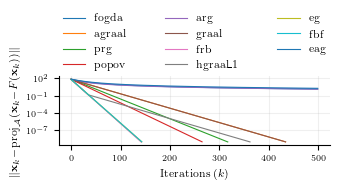

In [7]:
np.random.seed(2024)

# Problem data
n, M = 1000, 2000
c = np.random.normal(0, 100, size=(M,n))
r = 1 - np.linalg.norm(c, axis=0)

# Projection operator and VI mapping, with its Liptshitz constant
P = lambda x: np.where(
    np.linalg.norm(x - c) > r,
    r*(x - c) / np.linalg.norm(x - c, axis=0),
    x
)
F = lambda x: x - P(x).mean(axis=0)
L = 10

# Define the VI
fp = VI(F, n=n)

# Initial points
x0 = [np.random.rand(n) for _ in range(2)]

# Solve the VI using the available algorithms
max_iter = 200
for algorithm, params in cases(x0, L, excluded={"pg", "cfogda"}).items():
    print(f"Using: {algorithm}")
    sol = fp.solution(algorithm, params, max_iter, log_path=f"examples/logs/feasibility/{algorithm}.log")

plot_results(
    "examples/logs/feasibility",
    "examples/figs/feasibility.pdf",
    r"$\|\mathbf{x}_k \! - \! \text{proj}_{\mathcal{S}}(\mathbf{x}_k \! - \! F(\mathbf{x}_k))\|$"
)

## Two Players Zero-Sum Game
Many example of non-cooperative behavior between two adversarial agents can be modelled through zero-sum games. Let us consider vectors $\mathbf{x}_i \in \Delta_i$ as the decision variable of the $i$-th player, with $i \in \{1,2\}$, where $\Delta_i \subset \mathbb{R}^{n_i}$ is the simplex constraints set defined as $\Delta_i := \{\mathbf{x} \in \mathbb{R}^{n_i} : \mathbf{1}^\top \mathbf{x} = 1\}$, for all $i \in \{1,2\}$. Let $\mathbf{x} := \text{col}(\mathbf{x}_i)_{i = 1}^2$. The players try to solve the following problem
\begin{equation}
    \min_{\mathbf{x}_1 \in \Delta_1} \max_{\mathbf{x}_2 \in \Delta_2} \Phi(\mathbf{x}_1, \mathbf{x}_2)
\end{equation}
whose (Nash) equilibrium solution is achieved for $\mathbf{x}^*$ satisfying the following
\begin{equation}
    % \label{eq:saddle}
    \Phi(\mathbf{x}^*_1, \mathbf{x}_2) \leq \Phi(\mathbf{x}^*_1, \mathbf{x}^*_2) \leq \Phi(\mathbf{x}_1, \mathbf{x}^*_2), \quad \forall \mathbf{x} \in \Delta_1 \times \Delta_2
\end{equation}
For the sake of simplicity, we consider $\Phi(\mathbf{x}_1, \mathbf{x}_2) := \mathbf{x}^\top_1 \mathbf{H} \mathbf{x}_2$, for some $\mathbf{H} \in \mathbb{R}^{n_1 \times n_2}$. Doing so, the equilibrium condition in the previous equation can be written as a VI, with the mapping $F : \mathbb{R}^{n_1 + n_2} \to \mathbb{R}^{n_1 + n_2}$ defined as
\begin{equation}
    F(\mathbf{x}) = \begin{bmatrix} \mathbf{H} \mathbf{x}_1 \\ -\mathbf{H}^\top \mathbf{x}_2 \end{bmatrix} = \begin{bmatrix} & \mathbf{H} \\ -\mathbf{H}^\top & \end{bmatrix} \mathbf{x}
\end{equation}
and $\mathcal{S} = \Delta_1 \times \Delta_2$

Using: eg
Using: popov
Using: fbf
Using: frb
Using: prg
Using: eag
Using: arg
Using: graal
Using: agraal
Using: hgraal_1


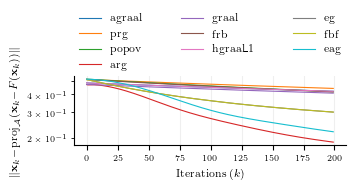

In [18]:
np.random.seed(2024)

n1, n2 = 50, 50

# Game matrix 
H = np.random.rand(n1, n2)
H_block = np.block([
    [np.zeros((n1,n2)), H                ],
    [-H.T,              np.zeros((n1,n2))]
])

# VI operators with Liptshitz constant
F = lambda x: H_block@x
L = np.linalg.norm(H_block, 2)

# Simplex constraints' set
x = cp.Variable(n1 + n2)
S = [
    cp.sum(x[:n1]) == 1,
    cp.sum(x[n1:]) == 1
]

# Define the two-players zero sum game as a Variational Inequality
tpzsg = VI(F, S=S)

# Create two initial (feasible) points
x0 = []
for i in range(2):
    x0.append(np.random.rand(n1 + n2)) 
    x0[i][:n1] /= x0[i][:n1].sum()
    x0[i][n1:] /= x0[i][n1:].sum()

# Solve the VI using the available algorithms
max_iter = 200
for algorithm, params in cases(x0, L, excluded={"pg", "fogda"}).items():
    print(f"Using: {algorithm}")
    sol = tpzsg.solution(algorithm, params, max_iter, log_path=f"examples/logs/zero-sum-game/{algorithm}.log")

# Plot the results
plot_results(
    "examples/logs/zero-sum-game",
    "examples/figs/zero-sum-game.pdf",
    r"$\|\mathbf{x}_k \! - \! \text{proj}_{\mathcal{S}}(\mathbf{x}_k \! - \! F(\mathbf{x}_k))\|$"
)

## Sparse logistic regression
Consider a dataset of $M$ rows and $N$ columns, so that $\mathbf{A} = \text{col}(\mathbf{a}^\top_i)_{i =1}^M \in \mathbb{R}^{M \times N}$ is the dataset matrix, and $\mathbf{a}_i \in \mathbb{R}^{N}$ is the $i$-th features vector for the $i$-th dataset row. Moreover, let $\mathbf{b} \in \mathbb{R}^M$ be the target vector, so that $b_i \in \{-1,1\}$ is the (binary) ground truth for the $i$-th data entry. 
The sparse logistic regression consists of finding the weight vector $\mathbf{x} \in \mathbb{R}^N$ that minimizes the following loss function 
$$
\begin{equation}
\begin{split}
f(\mathbf{x}) := \sum_{i = 1}^M \log\left(1 + \frac{1}{\exp(b_i \mathbf{a}^\top_i \mathbf{x})} \right) + \gamma \|\mathbf{x}\|_1
\\ = \underbrace{\mathbf{1}^\top_M \log(1 + \exp(-\mathbf{b} \odot \mathbf{A} \mathbf{x}))}_{=:s(\mathbf{x})} + \underbrace{\gamma \|\mathbf{x}\|_1}_{=:g(\mathbf{x})}
\end{split}
\end{equation}
$$
where $\gamma \in \mathbb{R}_{> 0}$ is the $\ell_1$-regulation strength. The gradient for $s(\cdot)$, $\nabla s_\mathbf{x}(\mathbf{x})$, is calculated as
$$
\begin{align}
    F(\mathbf{x}) &= \nabla s_\mathbf{x}(\mathbf{x}) = -\frac{\mathbf{A}^\top \odot (\mathbf{1}_N \otimes \mathbf{b}^\top) \odot \exp(-\mathbf{b} \odot \mathbf{A} \mathbf{x})}{1 + \exp(-\mathbf{b} \odot \mathbf{A} \mathbf{x})} \mathbf{1}_M
\end{align}
$$

Using: eg
Using: popov
Using: fbf
Using: frb
Using: prg
Using: eag
Using: arg
Using: fogda
Using: graal
Using: agraal
Using: hgraal_1


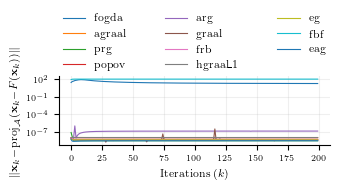

In [14]:
np.random.seed(2024)

N, M = 500, 200

# Train matrix, target vector, and regularization strength
A = np.random.normal(size=(M,N))
b = np.random.choice([-1,1], size=M)
gamma = 0.005*np.linalg.norm(A.T@b, np.inf)

# VI mapping
F = lambda x: -np.sum(
    (A.T*np.tile(b, (N,1)))*np.exp(-b*(A@x)) / (1 + np.exp(-b*(A@x))),
    axis=1
)
x = cp.Variable(N)
g = gamma*cp.norm(x, 1)
L = 2

# Define the VI problem
slr = VI(F, g)

# Initial points
x0 = [np.random.rand(N) for _ in range(2)]

# Solve the VI using the available algorithms
max_iter = 200
for algorithm, params in cases(x0, L, excluded={"pg"}).items():
    print(f"Using: {algorithm}")
    sol = slr.solution(algorithm, params, max_iter, log_path=f"examples/logs/logistic-regression/{algorithm}.log")

# Plot the results
plot_results(
    "examples/logs/logistic-regression",
    "examples/figs/logistic-regression.pdf",
    r"$\|\mathbf{x}_k \! - \! \text{proj}_{\mathcal{S}}(\mathbf{x}_k \! - \! F(\mathbf{x}_k))\|$"
)

## Skew-symmetric operator
A simple example of monotone operator that is not (even locally) strongly monotone is the skewed-symmetric operator, $F : \mathbb{R}^{MN} \to \mathbb{R}^{MN}$, which is described as follows
```math
    F(\mathbf{x}) = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_M \end{bmatrix} \mathbf{x}
```
for a given $M \in \mathbb{N}$, where $\mathbf{A}_i = \text{tril}(\mathbf{B}_i) - \text{triu}(\mathbf{B}_i)$, for some arbitrary $0 \preceq \mathbf{B}_i \in \mathbb{R}^{N \times N}$, for all $i = 1, \dots, M$. 

Using: eg
Using: popov
Using: fbf
Using: frb
Using: prg
Using: eag
Using: arg
Using: fogda
Using: graal
Using: agraal
Using: hgraal_1


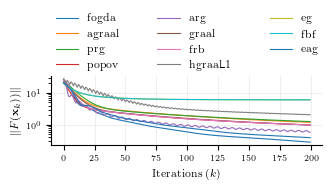

In [17]:
np.random.rand(2024)

M, N =  20, 10

# Create the problem variables
Bs = []
for _ in range(M):
    B = np.random.rand(N,N)
    B = (B + B.T)/2 # Make symmetric

    # Make positive semidefinite (through Gershgorin circle theorem)
    B += np.diag(((1 - I(N))*B).sum(axis=1)) 
    Bs.append(B)
    
A = sp.linalg.block_diag(*[np.tril(B) - np.triu(B) for B in Bs])

F = lambda x: A@x
L = np.linalg.norm(A, 2)

# Create the VI and the initial solution(s)
sso = VI(F, n=N*M)
x0 = [np.random.rand(N*M) for _ in range(2)]

# Solve the VI using the available algorithms
max_iter = 200
for algorithm, params in cases(x0, L, excluded={"pg"}).items():
    print(f"Using: {algorithm}")
    sol = sso.solution(
        algorithm, params, max_iter, eval_func=lambda x: np.linalg.norm(F(x), 2),
        log_path=f"examples/logs/skew-symmetric/{algorithm}.log"
    )

# Plot the results
plot_results(
    "examples/logs/skew-symmetric",
    "examples/figs/skew-symmetric.pdf",
    r"$\|F(\mathbf{x}_k))\|$"
)